# Hard Constrain Div Free on Turbulent Data

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

# verify cuda
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# device = 'cpu'
print('Torch in running on', device)

Torch in running on cuda:0


In [12]:
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

## Input data

Original size 256
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0
Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


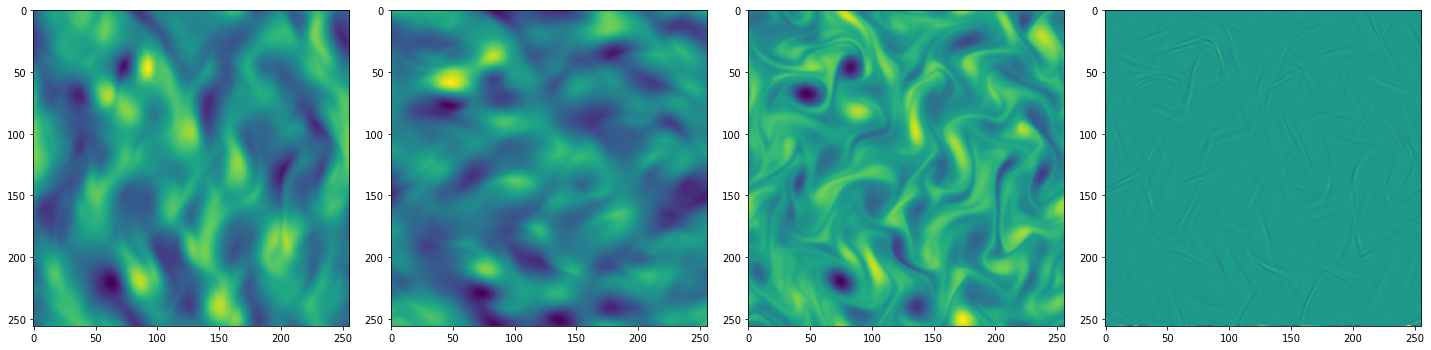

In [13]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 42
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2:]
t = np.arange(0,IMGs.shape[0],step=0.01)
Re = 3900

original_size = X.shape[0]
print('Original size', original_size)

# normalize output
y = U.copy()
print('Y shape', y.shape)
print('Y min, max:', np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print('after normalization, Y min, max:', np.min(y), np.max(y))

ytest = y.copy()
Xtest = X.copy()

W = phy.compute_vorticity(U[:,:,0],U[:,:,1])
D = phy.compute_divergence(U[:,:,0],U[:,:,1])

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(U[:,:,0])
plt.subplot(142)
plt.imshow(U[:,:,1])
plt.subplot(143)
plt.imshow(W)
plt.subplot(144)
plt.imshow(D)
plt.tight_layout()
plt.show()

Xtrain shape: (64, 64, 2)
ytrain shape: (64, 64, 2)


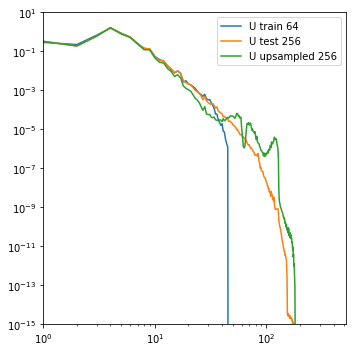

In [14]:
# downsampled resultion
scale = 1/4
coords = np.linspace(0, 1, int(original_size * scale), endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
Xtrain = coords
print('Xtrain shape:', Xtrain.shape)

y1ds = dsp.interpolate2D(X, y[:,:,0], scale=scale)[:,:,None]
y2ds = dsp.interpolate2D(X, y[:,:,1], scale=scale)[:,:,None]
ytrain = np.concatenate([y1ds, y2ds], axis=-1)
print('ytrain shape:', ytrain.shape)

# upsampled resolution
yup = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=4)[:,:,None]

# b1, b0, _r, _p_val, _stderr = stats.linregress(np.log10(mx), np.log10(my)) 

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.loglog(np.arange(len(phy.powerspec(yup[:,:,0]))), phy.powerspec(yup[:,:,0]), label='U upsampled 256')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()

# Dataset

In [15]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        assert np.max(np.abs(X)) <= 1

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('*** Dimension error ***')
            print('X', X.shape)
            print('y', y.shape)
            
        H, W, Cin = X.shape
        H, W, Cout = y.shape
        
        # reshape s.t. B = H*W of query points
        X = X.reshape(H*W, Cin)
        y = y.reshape(H*W, Cout)
        
        self.size = H*W
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]
        
        print(self.inputs.shape)
        print(self.inputs.shape)

    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, 
                 batch_size=2000, num_workers=8, shuffle=False):
        
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
X shape (64, 64, 2)
y shape (64, 64, 2)
torch.Size([4096, 2])
torch.Size([4096, 2])
Train
torch.Size([4096, 2]) torch.Size([4096, 2])


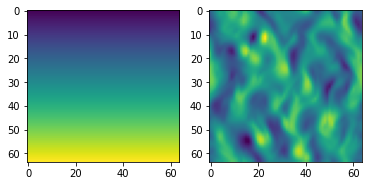

Validation
torch.Size([4096, 2]) torch.Size([4096, 2])


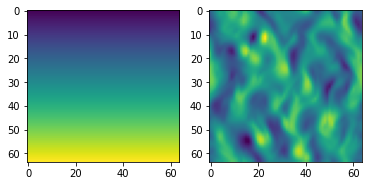

In [17]:
low_scale = 1/4
Xlow = np.concatenate([
            dsp.interpolate2D(X, Xtest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, Xtest[:,:,1], scale=low_scale)[:,:,None]], 
       axis=-1)
ylow = np.concatenate([
            dsp.interpolate2D(X, ytest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, ytest[:,:,1], scale=low_scale)[:,:,None]],
        axis=-1)

dm = DataModule(
    train_data=[Xlow, ylow],
    val_data=[Xlow, ylow],
    test_data=[Xlow, ylow],
    batch_size = 128**2,
    shuffle=False,
)

## test
dm.prepare_data()
print('Train')
for batch in dm.train_dataloader():
    x, y = batch
    print(x.shape, y.shape)
    
    plt.subplot(121)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(64,64,2)[:,:,0])
    plt.subplot(122)
    yshow = y.cpu().detach().numpy().squeeze()
    plt.imshow(yshow.reshape(64,64,2)[:,:,0])
    plt.show()
    
print('Validation')
for batch in dm.val_dataloader():
    x, y = batch
    print(x.shape, y.shape)
    plt.subplot(121)
    xshow = x.cpu().detach().numpy().squeeze()
    plt.imshow(xshow.reshape(64,64,2)[:,:,0])
    plt.subplot(122)
    yshow = y.cpu().detach().numpy().squeeze()
    plt.imshow(yshow.reshape(64,64,2)[:,:,0])
    plt.show()

# Model

## RFF on batch

In [36]:
class Fourier(nn.Module):
    
    def __init__(self, nfeat=256, scale=10):
        super(Fourier, self).__init__()
        self.b = torch.randn(2, nfeat)*scale
        self.pi = 3.14159265359

    def forward(self, x):
        x = torch.einsum('bc,cf->bf', 2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

    
def LinearReLU(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block


class RBFNet_divFree(nn.Module):
    def __init__(self, num_features=2, num_centers=100, device='cpu'):
        super(RBFNet_divFree, self).__init__()

        centers = torch.Tensor(num_centers, num_features)
        self.centers = nn.Parameter(centers).to(device)
        sigmas = torch.Tensor(num_centers)
        self.sigmas = nn.Parameter(sigmas).to(device)
        weights = torch.Tensor(num_centers, num_features)
        self.weights = nn.Parameter(weights).to(device)
        
        # initialize weights and biases
        nn.init.kaiming_uniform_(self.centers, a=2.236) # centers init
        nn.init.kaiming_uniform_(self.weights, a=2.236) # weights init
        
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.centers)
        bound = 1 / fan_in ** 0.5
        nn.init.uniform_(self.sigmas, 0, bound)  # bias init
        
        self.D = num_features
        self.eye = torch.eye(self.D).to(device)

    def kernel_fun(self, batches):
        cdist = torch.cdist(batches, self.centers) # N x C
        invSigma2 = 1/(self.sigmas**2) # 1 x C
        exp = torch.exp(-0.5*invSigma2*(cdist**2)) # N x C
        cdiff = batches[:,None,:] - self.centers[None,:,:]
        arg1 = torch.matmul(cdiff[...,None], cdiff[...,None,:])
        arg2 = ((self.D - 1) - invSigma2*(cdist**2))[...,None,None] * self.eye[None,None,...]
        kernel = invSigma2[...,None,None] * exp[...,None,None] * (arg1 + arg2)
        return torch.einsum('ncdd,cd->nd', kernel, self.weights)

    def forward(self, batches):
        return self.kernel_fun(batches)

    
class MLP(nn.Module):
    
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        layers = []
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearReLU(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(nn.Linear(dim_layers[-2], dim_layers[-1]))
        blocks.append(nn.Tanh())
        self.network = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.network(x)

    
class RFFNet_pl(pl.LightningModule):
    
    def __init__(self, dim_mpl_layers, f_nfeatures, f_scale, lam_pde=1e-4, device='cpu'):
        super(RFFNet_pl, self).__init__()
        
        # regression/pinn network
        self.rff = Fourier(f_nfeatures, f_scale)
        self.mlp = MLP(dim_mpl_layers)
        self.rbf = RBFNet_divFree(device=device)
        
        # PINN losses
        self.lam_pde = lam_pde
    
    def forward(self, x): # x := BxC(Batch, InputChannels)
        ## Fourier features
        x = self.rff(x) # Batch x Fourier Features
        ## MLP
        x = self.mlp(x)
        ## DivFree
        x = self.rbf(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        x_pred = self.forward(x)
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)
        # losses 
        loss = loss_rec
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_loss_data', loss_rec)
        return loss

    def validation_step(self, batch, batch_idx):
        x, x_true = batch
        x_pred = self.forward(x)
        loss = F.mse_loss(x_pred, x_true)
        self.log('valid_loss', loss, on_step=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [37]:
# TRAIN
n_features = 256
dim_mlp_layers = [2*n_features] + 3*[256] + [2]
scale = 10
model = RFFNet_pl(dim_mlp_layers, n_features, scale, lam_pde=0, device=device)

print(model)

early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=20, 
                     max_epochs=int(10e3), 
                     callbacks=[early_stop_callback])

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type           | Params
----------------------------------------
0 | rff  | Fourier        | 0     
1 | mlp  | MLP            | 263 K 
2 | rbf  | RBFNet_divFree | 0     
----------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)


RFFNet_pl(
  (rff): Fourier()
  (mlp): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=256, out_features=2, bias=True)
      (4): Tanh()
    )
  )
  (rbf): RBFNet_divFree()
)


Validation sanity check: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(262144, 2)


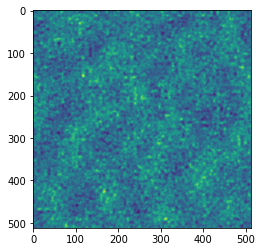

In [40]:
# TEST
ngrid = 512
model.eval().to(device)
coords = np.linspace(0, 1, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

pred = model(x)
ypred = pred.cpu().detach().numpy().squeeze()

plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0])
plt.show()

In [8]:
N = 64*64 # num train points
T = 128*128 # num test points
D = 2 # num dimensions

x = torch.randn(N,D) # train
y = torch.randn(T,D) # test

print('Train', x.shape)
print('Test', y.shape)

Train torch.Size([4096, 2])
Test torch.Size([16384, 2])


In [67]:
N = 100 # data points
D = 2 # num features
C = 10 # num centers 

X = torch.randn(N,D)
centers = torch.randn(C,D)
sigmas = torch.abs(torch.randn(C))
alphas = torch.randn(C,D)

print(centers.shape)
print(centers.shape)
print(sigmas.shape)

# # with for-loops
# for c in tqdm(range(C)):
#     for n in range(N):
#         invSigma2 = 1/(sigmas[c]**2)
#         dist = torch.norm(data[n,:] - centers[c,:])
#         exp = torch.exp(-0.5*invSigma2*(dist**2))
#         diff = data[n,:] - centers[c,:]
#         arg1 = torch.matmul(diff[:,None],diff[None,:])
#         arg2 = ((D - 1)- invSigma2*(dist**2))*np.eye(D)
#         res = invSigma2 * exp * (arg1 + arg2)
#         Kl[n,c,:,:] = res
        
# with torch broadcasts
cdist = torch.cdist(X, centers) # N x C
invSigma2 = 1/(sigmas[None,:]**2) # 1 x C
exp = torch.exp(-0.5*invSigma2*(cdist**2)) # N x C
cdiff = data[:,None,:] - centers[None,:,:]
arg1 = torch.matmul(cdiff[...,None], cdiff[...,None,:])
arg2 = ((D - 1) - invSigma2*(cdist**2))[...,None,None] * torch.eye(D)[None,None,...]
K = invSigma2[...,None,None] * exp[...,None,None] * (arg1 + arg2)

print(K.shape)
F = torch.einsum('ncdd,cd->nd', K, alphas)
print(F.shape)

print(X)
print(F)


torch.Size([10, 2])
torch.Size([10, 2])
torch.Size([10])
torch.Size([100, 10, 2, 2])
torch.Size([100, 2])
tensor([[ 2.0200,  0.2437],
        [-1.1935,  0.0782],
        [ 0.5259,  0.6469],
        [-1.2768,  0.7464],
        [-2.1665, -1.0449],
        [-1.4204, -0.2262],
        [ 0.6652, -0.8240],
        [ 0.5431, -0.4910],
        [-0.8364,  0.9674],
        [ 0.5715, -0.8519],
        [ 1.1298,  1.4969],
        [ 0.1620,  1.0682],
        [-0.5114, -0.8052],
        [-0.0787, -0.7086],
        [ 1.2733, -0.5482],
        [-1.7242,  0.3820],
        [ 0.9405, -0.2880],
        [-0.6504,  1.4206],
        [-0.7003,  0.9099],
        [-0.1440,  0.5774],
        [-1.6527, -0.0772],
        [ 1.0239,  0.2111],
        [-0.6203, -0.8850],
        [ 0.0544, -1.2006],
        [-0.3369, -2.1904],
        [ 0.3295,  0.6012],
        [ 1.6096, -0.4144],
        [ 0.9040,  1.2190],
        [ 1.0622, -0.4406],
        [ 0.5773, -0.8289],
        [ 0.4603, -0.2197],
        [ 0.3030,  1.7220]

In [85]:
class RBFNet_divFree(nn.Module):
    def __init__(self, num_features=2, num_centers=100):
        super(RBFNet_divFree, self).__init__()

        centers = torch.Tensor(num_centers, num_features)
        self.centers = nn.Parameter(centers)
        sigmas = torch.Tensor(num_centers)
        self.sigmas = nn.Parameter(sigmas)
        
        # initialize weights and biases
        nn.init.kaiming_uniform_(self.centers, a=2.236) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.centers)
        bound = 1 / fan_in ** 0.5
        nn.init.uniform_(self.sigmas, 0, bound)  # bias init

    def kernel_fun(self, batches):      
        cdist = torch.cdist(batches, self.centers) # N x C
        invSigma2 = 1/(self.sigmas**2) # 1 x C
        exp = torch.exp(-0.5*invSigma2*(cdist**2)) # N x C
        cdiff = data[:,None,:] - self.centers[None,:,:]
        arg1 = torch.matmul(cdiff[...,None], cdiff[...,None,:])
        arg2 = ((D - 1) - invSigma2*(cdist**2))[...,None,None] * torch.eye(D)[None,None,...]
        K = invSigma2[...,None,None] * exp[...,None,None] * (arg1 + arg2)
        return K

    def forward(self, batches):
        radial_val = self.kernel_fun(batches)
        return radial_val

tensor([[[[-1.1201e-12, -1.4104e-14],
          [-1.4104e-14, -1.2188e-12]],

         [[-4.7574e-10, -1.7378e-11],
          [-1.7378e-11, -4.7654e-10]],

         [[-4.8530e-02, -1.8283e-02],
          [-1.8283e-02, -6.3114e-02]],

         ...,

         [[-1.2010e-12, -2.4613e-14],
          [-2.4613e-14, -1.2937e-12]],

         [[-1.0801e-03, -6.9776e-05],
          [-6.9776e-05, -1.0936e-03]],

         [[-1.0094e-05, -4.5599e-07],
          [-4.5599e-07, -1.1474e-05]]],


        [[[-2.9873e-20, -3.4421e-22],
          [-3.4421e-22, -2.9989e-20]],

         [[-7.8478e-01, -3.9888e-02],
          [-3.9888e-02, -3.6928e-01]],

         [[-4.9465e-01, -1.5120e-01],
          [-1.5120e-01, -1.6856e-01]],

         ...,

         [[-8.2979e-15, -1.4336e-16],
          [-1.4336e-16, -8.2600e-15]],

         [[-4.9772e-01,  7.3927e-02],
          [ 7.3927e-02,  4.0285e+00]],

         [[-1.3121e-03, -6.7615e-05],
          [-6.7615e-05, -1.2602e-03]]],


        [[[ 4.1201e+00,  3.523

In [ ]:
def divfree_kernel(x, xt, s=1):
    assert x.shape[-1] == xt.shape[-1]
    D = x.shape[-1]
    
    sqr_dist = (torch.cdist(x,xt)**2)/(s**2) # (test x train)
    gauss_dist = torch.exp(-sqr_dist/2)
    
    cross = (x[:,None,:] - xt[None,:,:])/s
    H = cross[:,:,:,None] @ cross[:,:,None,:]
    trHI = ((D-1) - (sqr_dist[:,:,None,None]))*torch.eye(D)
    return (1./(sigma**2))*gauss_dist[:,:,None,None]*(H-trHI)

Kdf = divfree_kernel(xt, x, s=10)

f = torch.einsum('tndd,dn->td',Kdf,a)

print(f.shape)
D = phy.compute_divergence(f[:,0].numpy().reshape(128,128),
                           f[:,1].numpy().reshape(128,128))

plt.imshow(D)